# 03. PyTorch Neural Network Classification

## What is a classification problem?

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:

| Problem type | What is it? | Example |
| ----- | ----- | ----- |
| **Binary classification** | Target can be one of two options, e.g. yes or no | Predict whether or not someone has heart disease based on their health parameters. |
| **Multi-class classification** | Target can be one of more than two options | Decide whether a photo of is of food, a person or a dog. |
| **Multi-label classification** | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosohpy). |


## 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

## 1. Make classification data and get it ready

We'll use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) method from Scikit-Learn to generate two circles with different coloured dots. 

In [6]:
from sklearn.datasets import make_circles

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.05, # a little bit of noise to the dots
                    random_state=42, # keep random state so we get the same values
                    factor = 0.8) 

In [7]:
y[:3]

array([1, 1, 1])

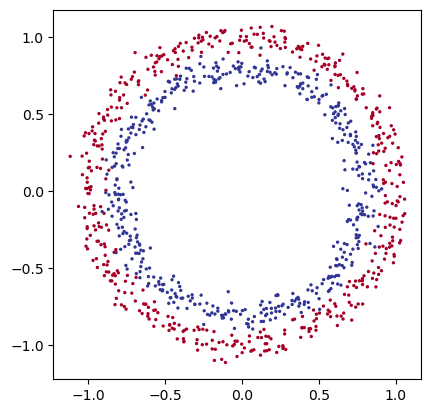

In [8]:
# Visualize with a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)

ax.scatter(x=X[:, 0], y=X[:, 1], c=y, s=2, cmap=plt.cm.RdYlBu)
ax.set_aspect('equal', 'box')
plt.show()

Looks like there's two `X` values per one `y` value. 

In [9]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(5)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0


In [10]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

In [11]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [12]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Create neural network

In [14]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

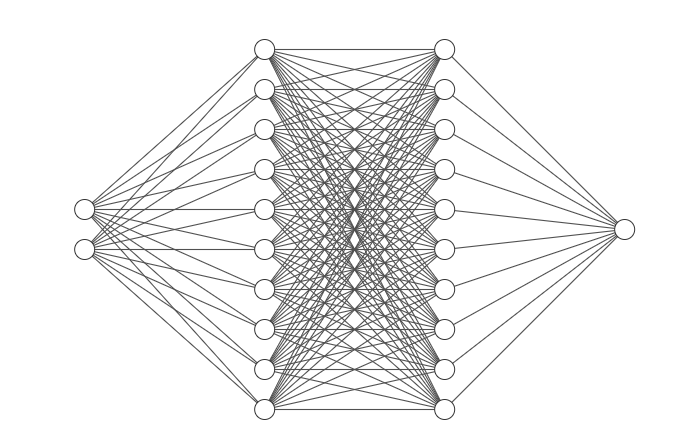

In [15]:
# 1. Construct a model class that subclasses nn.Module
class CircleModel(nn.Module):
    def __init__(self, n1, n2):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=n1) # input -> 1 hidden layer
        self.layer_2 = nn.Linear(in_features=n1, out_features=n2) # 1 hidden layer -> 2 hidden layer
        self.layer_3 = nn.Linear(in_features=n2, out_features=1) # 2 hidden layer -> output
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        # x = self.layer_1(x)
        # x = self.relu(x)
        # x = self.layer_2(x)
        # x = self.relu(x)
        # x = self.layer_3(x)
        # return x
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [16]:
# 4. Create an instance of the model and send it to target device
model = CircleModel(10, 10).to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [17]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0954,  0.5397],
         [ 0.5399,  0.2044],
         [-0.3262,  0.5385],
         [ 0.0937, -0.5038],
         [-0.2705,  0.0212],
         [ 0.5024,  0.5644],
         [-0.0350,  0.0304],
         [-0.0050,  0.2582],
         [-0.6623,  0.6632],
         [-0.6492, -0.2448]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.1046,  0.3758,  0.6579, -0.4676, -0.5931, -0.2493, -0.3421, -0.6478,
          0.1231,  0.4051], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.2918,  0.2248, -0.1531, -0.1884, -0.0032,  0.1893,  0.0925, -0.1739,
           0.1617, -0.2724],
         [ 0.0044, -0.1339, -0.2255,  0.2264, -0.2976,  0.1320,  0.0826,  0.1034,
           0.2224, -0.0523],
         [-0.1151,  0.0170,  0.1403,  0.1544, -0.1037,  0.0077,  0.1715, -0.2518,
          -0.1458, -0.1260],
         [-0.1564,  0.1689,  0.0616,  0.0656,  0.2903,  0.0982, -0.2138,  0.2426,
           0.1997,  0.1095],
         [ 

In [18]:
# Create a loss function
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.3)

In [19]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## 3. Train model

In [20]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 3000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69339, Accuracy: 50.00% | Test loss: 0.69248, Test acc: 50.00%
Epoch: 100 | Loss: 0.68191, Accuracy: 53.75% | Test loss: 0.68215, Test acc: 55.50%
Epoch: 200 | Loss: 0.65086, Accuracy: 70.75% | Test loss: 0.65852, Test acc: 63.00%
Epoch: 300 | Loss: 0.49146, Accuracy: 95.12% | Test loss: 0.52769, Test acc: 91.00%
Epoch: 400 | Loss: 0.44840, Accuracy: 70.50% | Test loss: 0.53053, Test acc: 62.00%
Epoch: 500 | Loss: 0.28453, Accuracy: 87.75% | Test loss: 0.38984, Test acc: 78.00%
Epoch: 600 | Loss: 0.12130, Accuracy: 97.62% | Test loss: 0.21184, Test acc: 93.50%
Epoch: 700 | Loss: 0.08940, Accuracy: 97.88% | Test loss: 0.18510, Test acc: 93.50%
Epoch: 800 | Loss: 0.08158, Accuracy: 98.12% | Test loss: 0.17781, Test acc: 93.50%
Epoch: 900 | Loss: 0.06473, Accuracy: 98.38% | Test loss: 0.16869, Test acc: 93.00%
Epoch: 1000 | Loss: 0.05741, Accuracy: 98.38% | Test loss: 0.16636, Test acc: 92.50%
Epoch: 1100 | Loss: 0.06423, Accuracy: 98.00% | Test loss: 0.16385, Test acc:

## 4. Make predictions and evaluate the model

In [22]:
from helper_functions import plot_predictions, plot_decision_boundary

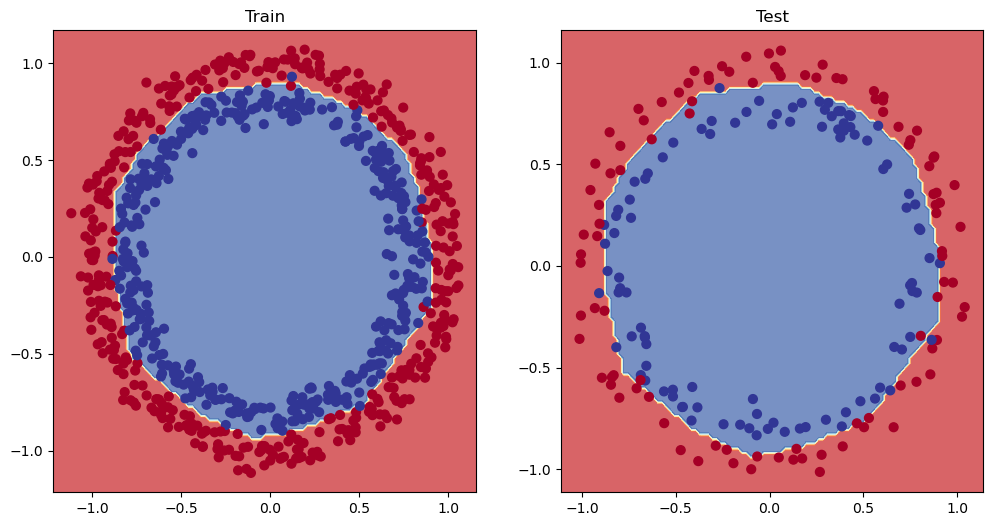

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## 5. Multi-class PyTorch model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


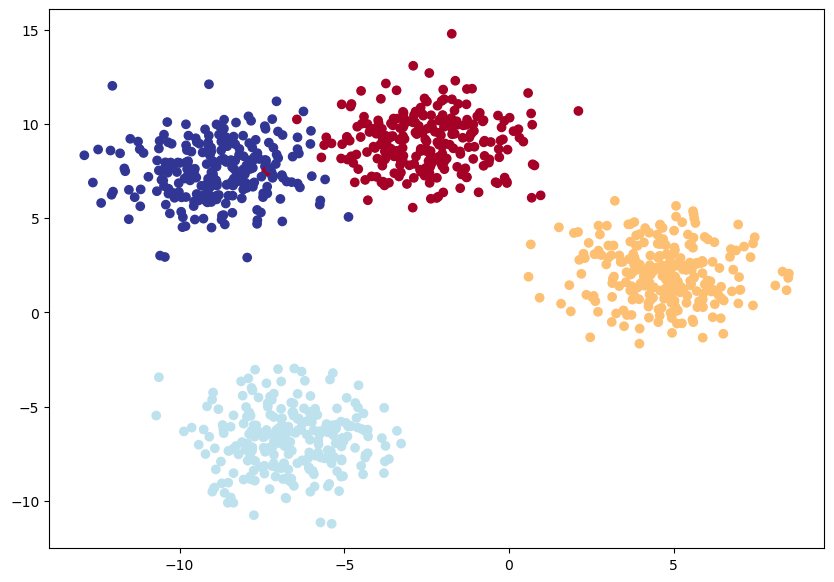

In [24]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED,
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [25]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

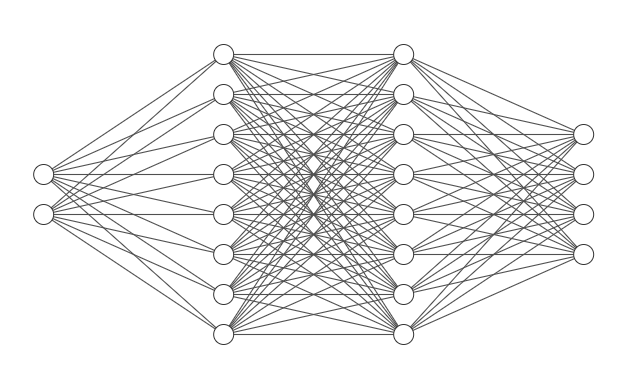

In [26]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)


In [27]:
# Create an instance of BlobModel and send it to the target device
model_2 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_2

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [28]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [29]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 300

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_2.train()

    # 1. Forward pass
    y_logits = model_2(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_2(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 100 | Loss: 0.03312, Acc: 99.25% | Test Loss: 0.02433, Test Acc: 99.50%
Epoch: 200 | Loss: 0.02657, Acc: 99.25% | Test Loss: 0.01651, Test Acc: 99.50%


In [30]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_logits = model_2(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -1.0652,   8.2797,  -9.1449, -10.2100],
        [ -2.4756,  -7.7620,  -4.9026,   4.3641],
        [ -4.5196,  -4.9315,   4.3766,  -3.4838],
        [ -1.7697,   5.9512,  -4.7679,  -5.8968],
        [  5.3451,  -1.6305, -10.8774,  -8.3669],
        [ -3.1531,  -9.2199,  -5.7116,   5.2367],
        [ -3.9928,  -4.2288,   3.8460,  -2.8900],
        [  4.7622,  -5.1602,  -8.3182,  -4.2139],
        [ -5.7480,  -6.2989,   5.3564,  -4.4740],
        [  4.9970,  -3.8428,  -9.0331,  -5.6023]], device='cuda:0')

In [31]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


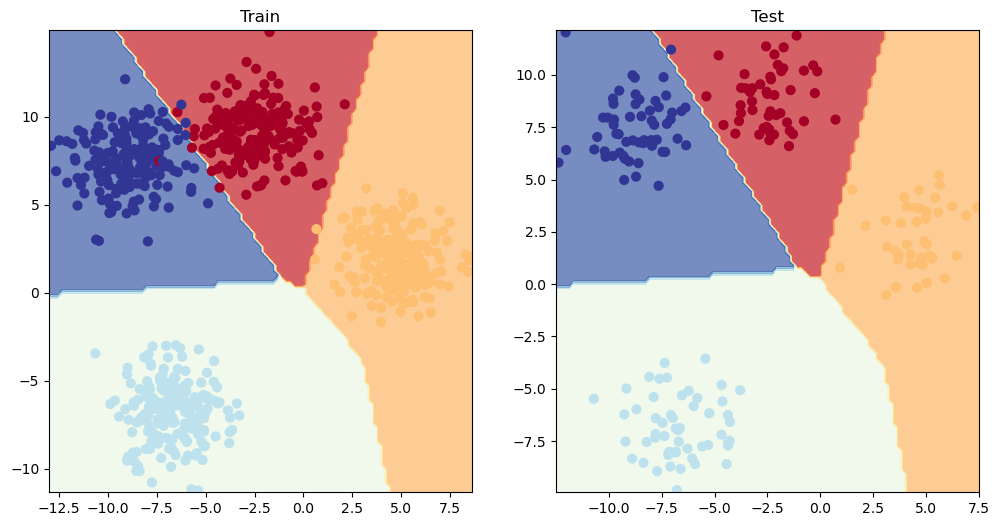

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_blob_test, y_blob_test)

## Exercises

1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
    * For consistency, the dataset should have 1000 samples and a `random_state=42`.
    * Turn the data into PyTorch tensors. Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.
2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
    * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.
3. Setup a binary classification compatible loss function and optimizer to use when training the model.
4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
    * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
    * Train the model for long enough for it to reach over 96% accuracy.
    * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.
5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.